In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_data():
    mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    y = y.astype(np.int32)  # Convert target to integers
    return X, y


def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def avg_pooling(image, pool_size):
    pooled_height = image.shape[0] // pool_size[0]
    pooled_width = image.shape[1] // pool_size[1]
    pooled_image = np.zeros((pooled_height, pooled_width))

    for i in range(pooled_height):
        for j in range(pooled_width):
            start_i, end_i = i * pool_size[0], (i + 1) * pool_size[0]
            start_j, end_j = j * pool_size[1], (j + 1) * pool_size[1]
            pooled_image[i, j] = np.mean(image[start_i:end_i, start_j:end_j])

    return pooled_image


def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [2]:
import tqdm

# Load and split the data
X, y = load_data()

pool_size = 3
X_pooled = np.zeros((X.shape[0], (28 // pool_size) * (28 // pool_size)))
for i in tqdm.tqdm(range(X.shape[0])):
    image = X[i].reshape(28, 28)
    pooled_image = avg_pooling(image, (pool_size, pool_size))
    X_pooled[i] = pooled_image.flatten()

X_train, X_test, y_train, y_test = split_data(X_pooled, y)

# Preprocess the data
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
100%|██████████| 70000/70000 [00:52<00:00, 1327.47it/s]


In [3]:
import sys
sys.path.append('D:\calvera\src')

In [4]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [7]:
import torch

from neural_bandits.algorithms.neural_ucb_bandit import NeuralUCB
from neural_bandits.trainers.neural_ucb_trainer import NeuralUCBTrainer
from neural_bandits.utils.multiclass import MultiClassContextualiser

def train_neural_ucb_mnist(X_train_scaled, y_train, n_samples: int = 10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_features = X_train_scaled.shape[1]
    n_arms = 10

    network = Network(n_features * n_arms, hidden_size=100)
    
    # Initialize bandit
    bandit = NeuralUCB(
        network=network,
        n_arms=n_arms,
        n_features=n_features * n_arms,
        lambda_=0.00001,
        nu=0.00001,
    ).to(device)
    
    trainer = NeuralUCBTrainer(eta=0.01)
    mc_contextualiser = MultiClassContextualiser(n_arms)
    
    total_regret = []
    
    for t in tqdm.tqdm(range(n_samples)):
        x_tensor = torch.tensor(X_train_scaled[t], dtype=torch.float32).to(device).reshape(1, -1)
        contextualised_actions = mc_contextualiser.contextualise(x_tensor)
        # print("contextualised_actions.shape: ", contextualised_actions.shape)
        
        # Select action
        ucb_scores = bandit(contextualised_actions)
        chosen_arm = torch.argmax(ucb_scores, dim=1).item()
        
        # Get reward
        reward = 1.0 if y_train[t] == chosen_arm else 0.0
        reward = torch.tensor([reward], dtype=torch.float32, device=device).reshape(1, -1)
        total_regret.append(1 - reward.item())
        
        # Extract features for chosen arm
        contextualised_actions = contextualised_actions.squeeze(0)
        chosen_features = contextualised_actions[chosen_arm]
        # print("chosen_features.shape: ", chosen_features.shape)
        
        # Update bandit
        if t < 1000:
            bandit = trainer.update(bandit, reward, chosen_features)
        else:
            if t % 100 == 0:
                bandit = trainer.update(bandit, reward, chosen_features)

        if t % 100 == 0:
            print(f"Step {t}:")
            print(f"UCB Scores: {ucb_scores}")
            print(f"Chosen arm: {chosen_arm}")
            print(f"True label: {y_train[t]}")
            print(f"Average regret: {sum(total_regret)/(t+1)}")
    
    return bandit, total_regret

In [8]:
# Train the neural UCB bandit
bandit, regret = train_neural_ucb_mnist(X_train_scaled, y_train)

# Print results
print("Total regret:", sum(regret))
print("Average regret:", sum(regret) / len(regret))

  0%|          | 6/10000 [00:01<31:48,  5.24it/s]  

Step 0:
UCB Scores: tensor([[0.1005, 0.1034, 0.0936, 0.1053, 0.0970, 0.1010, 0.0948, 0.1032, 0.1007,
         0.1005]])
Chosen arm: 3
True label: 5
Average regret: 1.0


  1%|          | 101/10000 [00:12<31:23,  5.26it/s]

Step 100:
UCB Scores: tensor([[0.1221, 0.1007, 0.0969, 0.0984, 0.0898, 0.1320, 0.0738, 0.1064, 0.0905,
         0.0894]])
Chosen arm: 5
True label: 0
Average regret: 0.7722772277227723


  2%|▏         | 202/10000 [00:37<41:48,  3.91it/s]  

Step 200:
UCB Scores: tensor([[0.0885, 0.0923, 0.1173, 0.0853, 0.0791, 0.1332, 0.1645, 0.0859, 0.0848,
         0.0692]])
Chosen arm: 6
True label: 6
Average regret: 0.6318407960199005


  3%|▎         | 302/10000 [01:07<37:11,  4.35it/s]  

Step 300:
UCB Scores: tensor([[0.0985, 0.0739, 0.0812, 0.2159, 0.0848, 0.0693, 0.0780, 0.0819, 0.0956,
         0.1209]])
Chosen arm: 3
True label: 3
Average regret: 0.5382059800664452


  4%|▍         | 401/10000 [01:46<50:50,  3.15it/s]  

Step 400:
UCB Scores: tensor([[0.0931, 0.1045, 0.0857, 0.1368, 0.1134, 0.1033, 0.0975, 0.0938, 0.0861,
         0.0858]])
Chosen arm: 3
True label: 7
Average regret: 0.5236907730673317


  5%|▌         | 501/10000 [02:26<55:39,  2.84it/s]  

Step 500:
UCB Scores: tensor([[0.0843, 0.1824, 0.0766, 0.1041, 0.0799, 0.0441, 0.0875, 0.1475, 0.0813,
         0.1123]])
Chosen arm: 1
True label: 1
Average regret: 0.4550898203592814


  6%|▌         | 601/10000 [03:19<1:08:07,  2.30it/s]

Step 600:
UCB Scores: tensor([[0.0659, 0.0715, 0.0649, 0.0809, 0.1152, 0.0251, 0.0877, 0.2240, 0.1341,
         0.1307]])
Chosen arm: 7
True label: 7
Average regret: 0.41430948419301167


  7%|▋         | 701/10000 [04:10<1:31:18,  1.70it/s]

Step 700:
UCB Scores: tensor([[0.1027, 0.1919, 0.1074, 0.0799, 0.1089, 0.0139, 0.0839, 0.0969, 0.1232,
         0.0912]])
Chosen arm: 1
True label: 1
Average regret: 0.37375178316690444


  8%|▊         | 801/10000 [05:06<1:24:37,  1.81it/s]

Step 800:
UCB Scores: tensor([[0.1104, 0.0531, 0.0744, 0.1575, 0.0676, 0.0946, 0.0750, 0.1396, 0.1302,
         0.0975]])
Chosen arm: 3
True label: 3
Average regret: 0.352059925093633


  9%|▉         | 901/10000 [06:14<1:56:41,  1.30it/s]

Step 900:
UCB Scores: tensor([[0.0735, 0.0623, 0.0578, 0.1156, 0.0915, 0.1810, 0.0693, 0.0845, 0.1019,
         0.1625]])
Chosen arm: 5
True label: 5
Average regret: 0.3263041065482797


 10%|█         | 1035/10000 [07:26<06:25, 23.26it/s]  

Step 1000:
UCB Scores: tensor([[0.0729, 0.2127, 0.1394, 0.0721, 0.0935, 0.0466, 0.0924, 0.0841, 0.1182,
         0.0681]])
Chosen arm: 1
True label: 1
Average regret: 0.31368631368631367


 11%|█         | 1123/10000 [07:27<03:09, 46.92it/s]

Step 1100:
UCB Scores: tensor([[0.0977, 0.0714, 0.0801, 0.0783, 0.1325, 0.0603, 0.0899, 0.1464, 0.0713,
         0.1720]])
Chosen arm: 9
True label: 9
Average regret: 0.29427792915531337


 12%|█▏        | 1228/10000 [07:29<02:39, 54.86it/s] 

Step 1200:
UCB Scores: tensor([[0.0853, 0.0470, 0.0517, 0.1280, 0.0920, 0.1052, 0.0700, 0.1204, 0.1210,
         0.1794]])
Chosen arm: 9
True label: 9
Average regret: 0.2880932556203164


 13%|█▎        | 1335/10000 [07:30<02:07, 67.83it/s] 

Step 1300:
UCB Scores: tensor([[0.0735, 0.0785, 0.1237, 0.2521, 0.0789, 0.0709, 0.0602, 0.0919, 0.0871,
         0.0832]])
Chosen arm: 3
True label: 3
Average regret: 0.2759415833973866


 14%|█▍        | 1413/10000 [07:31<03:25, 41.79it/s] 

Step 1400:
UCB Scores: tensor([[0.1069, 0.0437, 0.0697, 0.1415, 0.0725, 0.1903, 0.0883, 0.0673, 0.1072,
         0.1126]])
Chosen arm: 5
True label: 5
Average regret: 0.2698072805139186


 15%|█▌        | 1516/10000 [07:33<03:09, 44.72it/s]

Step 1500:
UCB Scores: tensor([[0.1716, 0.0896, 0.0605, 0.1727, 0.1026, 0.0334, 0.1305, 0.1051, 0.0200,
         0.1141]])
Chosen arm: 3
True label: 7
Average regret: 0.26582278481012656


 16%|█▌        | 1618/10000 [07:35<03:47, 36.78it/s] 

Step 1600:
UCB Scores: tensor([[0.0615, 0.0830, 0.0662, 0.1184, 0.1401, 0.1478, 0.0685, 0.0884, 0.1486,
         0.0773]])
Chosen arm: 8
True label: 8
Average regret: 0.25921299188007496


 17%|█▋        | 1735/10000 [07:37<02:25, 56.87it/s] 

Step 1700:
UCB Scores: tensor([[0.1380, 0.0886, 0.0945, 0.0930, 0.0671, 0.0659, 0.1194, 0.1186, 0.1577,
         0.0571]])
Chosen arm: 8
True label: 6
Average regret: 0.2533803644914756


 18%|█▊        | 1828/10000 [07:38<02:19, 58.61it/s] 

Step 1800:
UCB Scores: tensor([[0.0978, 0.0581, 0.0891, 0.0733, 0.0908, 0.0617, 0.1285, 0.1618, 0.0955,
         0.1434]])
Chosen arm: 7
True label: 4
Average regret: 0.249305941143809


 19%|█▉        | 1935/10000 [07:39<01:53, 71.25it/s] 

Step 1900:
UCB Scores: tensor([[0.1034, 0.0452, 0.0854, 0.0924, 0.0789, 0.0477, 0.1119, 0.0651, 0.2198,
         0.1503]])
Chosen arm: 8
True label: 8
Average regret: 0.24355602314571279


 20%|██        | 2023/10000 [07:41<02:04, 64.25it/s] 

Step 2000:
UCB Scores: tensor([[0.0635, 0.0784, 0.1058, 0.0997, 0.1873, 0.0584, 0.0844, 0.0981, 0.0255,
         0.1990]])
Chosen arm: 9
True label: 4
Average regret: 0.24087956021989004


 21%|██▏       | 2132/10000 [07:42<01:54, 68.50it/s] 

Step 2100:
UCB Scores: tensor([[0.1001, 0.0741, 0.1251, 0.1380, 0.0980, 0.0428, 0.1398, 0.0928, 0.0680,
         0.1214]])
Chosen arm: 6
True label: 3
Average regret: 0.23750594954783436


 22%|██▏       | 2225/10000 [07:43<01:49, 70.81it/s] 

Step 2200:
UCB Scores: tensor([[0.0718, 0.0725, 0.0617, 0.0615, 0.0801, 0.0848, 0.0780, 0.2660, 0.1054,
         0.1182]])
Chosen arm: 7
True label: 7
Average regret: 0.23398455247614722


 23%|██▎       | 2335/10000 [07:44<01:48, 70.43it/s] 

Step 2300:
UCB Scores: tensor([[0.1205, 0.0985, 0.3097, 0.0472, 0.0499, 0.0851, 0.0995, 0.0798, 0.0699,
         0.0399]])
Chosen arm: 2
True label: 2
Average regret: 0.23424598000869187


 24%|██▍       | 2434/10000 [07:46<01:39, 76.32it/s] 

Step 2400:
UCB Scores: tensor([[0.2083, 0.0549, 0.0996, 0.0805, 0.0604, 0.0819, 0.1329, 0.0699, 0.1190,
         0.0925]])
Chosen arm: 0
True label: 0
Average regret: 0.2299042065805914


 25%|██▌       | 2521/10000 [07:47<01:50, 67.75it/s] 

Step 2500:
UCB Scores: tensor([[0.1980, 0.1059, 0.1380, 0.0717, 0.0935, 0.1330, 0.1167, 0.0715, 0.0445,
         0.0272]])
Chosen arm: 0
True label: 0
Average regret: 0.2267093162734906


 26%|██▋       | 2626/10000 [07:48<01:52, 65.75it/s] 

Step 2600:
UCB Scores: tensor([[0.0835, 0.0679, 0.0954, 0.2060, 0.0827, 0.0825, 0.0536, 0.0859, 0.1585,
         0.0839]])
Chosen arm: 3
True label: 3
Average regret: 0.2233756247597078


 27%|██▋       | 2736/10000 [07:49<01:35, 76.44it/s] 

Step 2700:
UCB Scores: tensor([[0.0848, 0.1633, 0.1281, 0.1131, 0.0666, 0.0767, 0.0554, 0.0688, 0.1073,
         0.1359]])
Chosen arm: 1
True label: 1
Average regret: 0.22139948167345427


 28%|██▊       | 2825/10000 [07:51<01:43, 69.66it/s] 

Step 2800:
UCB Scores: tensor([[0.0803, 0.2086, 0.1191, 0.1134, 0.0795, 0.0355, 0.0812, 0.1127, 0.0955,
         0.0742]])
Chosen arm: 1
True label: 1
Average regret: 0.2202784719742949


 29%|██▉       | 2938/10000 [07:52<01:38, 71.69it/s] 

Step 2900:
UCB Scores: tensor([[0.1891, 0.1051, 0.0824, 0.0729, 0.0977, 0.0633, 0.1340, 0.1585, 0.0499,
         0.0470]])
Chosen arm: 0
True label: 0
Average regret: 0.21923474663908996


 30%|███       | 3019/10000 [07:53<01:55, 60.39it/s] 

Step 3000:
UCB Scores: tensor([[0.1106, 0.0780, 0.1153, 0.1166, 0.0791, 0.0548, 0.0974, 0.1098, 0.1022,
         0.1363]])
Chosen arm: 9
True label: 3
Average regret: 0.21559480173275575


 31%|███▏      | 3131/10000 [07:54<01:35, 71.70it/s] 

Step 3100:
UCB Scores: tensor([[0.0504, 0.0828, 0.0897, 0.0923, 0.1111, 0.0984, 0.1364, 0.1191, 0.0413,
         0.1786]])
Chosen arm: 9
True label: 9
Average regret: 0.21380199935504676


 32%|███▏      | 3237/10000 [07:56<01:20, 83.96it/s] 

Step 3200:
UCB Scores: tensor([[0.1122, 0.0382, 0.1012, 0.1461, 0.1383, 0.0177, 0.1638, 0.1097, 0.0740,
         0.0988]])
Chosen arm: 6
True label: 4
Average regret: 0.21180880974695407


 33%|███▎      | 3321/10000 [07:57<01:44, 64.09it/s] 

Step 3300:
UCB Scores: tensor([[0.0879, 0.1998, 0.0612, 0.1325, 0.0674, 0.0614, 0.0740, 0.0582, 0.1497,
         0.1079]])
Chosen arm: 1
True label: 1
Average regret: 0.20902756740381703


 34%|███▍      | 3430/10000 [07:58<01:34, 69.37it/s] 

Step 3400:
UCB Scores: tensor([[0.0821, 0.2157, 0.1210, 0.1455, 0.0931, 0.0240, 0.0860, 0.0709, 0.1005,
         0.0612]])
Chosen arm: 1
True label: 1
Average regret: 0.20788003528374008


 35%|███▌      | 3532/10000 [07:59<01:33, 69.09it/s] 

Step 3500:
UCB Scores: tensor([[0.0981, 0.0589, 0.1139, 0.2421, 0.0684, 0.1126, 0.0567, 0.0714, 0.1114,
         0.0665]])
Chosen arm: 3
True label: 3
Average regret: 0.20536989431590974


 36%|███▌      | 3621/10000 [08:00<01:33, 67.89it/s] 

Step 3600:
UCB Scores: tensor([[0.0854, 0.0783, 0.2955, 0.0215, 0.0835, 0.0690, 0.1537, 0.0818, 0.0964,
         0.0349]])
Chosen arm: 2
True label: 2
Average regret: 0.2052207720077756


 37%|███▋      | 3730/10000 [08:02<01:29, 70.34it/s] 

Step 3700:
UCB Scores: tensor([[0.0635, 0.1283, 0.0786, 0.1982, 0.0916, 0.0627, 0.0424, 0.0567, 0.1335,
         0.1445]])
Chosen arm: 3
True label: 3
Average regret: 0.20345852472304782


 38%|███▊      | 3830/10000 [08:03<01:33, 65.94it/s] 

Step 3800:
UCB Scores: tensor([[0.0991, 0.0924, 0.1570, 0.0807, 0.1166, 0.0163, 0.1078, 0.0908, 0.0583,
         0.1810]])
Chosen arm: 9
True label: 2
Average regret: 0.20099973691133913


 39%|███▉      | 3930/10000 [08:04<01:34, 64.44it/s] 

Step 3900:
UCB Scores: tensor([[0.0919, 0.1169, 0.1475, 0.0789, 0.0734, 0.0802, 0.0658, 0.0987, 0.1445,
         0.1022]])
Chosen arm: 2
True label: 8
Average regret: 0.2019994873109459


 40%|████      | 4028/10000 [08:06<01:38, 60.58it/s] 

Step 4000:
UCB Scores: tensor([[0.0738, 0.1003, 0.0700, 0.0485, 0.1033, 0.2475, 0.0705, 0.1119, 0.1168,
         0.0572]])
Chosen arm: 5
True label: 5
Average regret: 0.20069982504373907


 41%|████▏     | 4133/10000 [08:07<01:23, 69.85it/s] 

Step 4100:
UCB Scores: tensor([[0.1257, 0.0939, 0.1421, 0.1019, 0.1413, 0.0849, 0.0940, 0.1052, 0.0528,
         0.0582]])
Chosen arm: 2
True label: 4
Average regret: 0.19897585954645208


 42%|████▏     | 4220/10000 [08:08<01:26, 67.21it/s] 

Step 4200:
UCB Scores: tensor([[0.0743, 0.1528, 0.1127, 0.1389, 0.0820, 0.0636, 0.0716, 0.1124, 0.0649,
         0.1268]])
Chosen arm: 1
True label: 1
Average regret: 0.19733396810283266


 43%|████▎     | 4327/10000 [08:09<01:18, 72.45it/s] 

Step 4300:
UCB Scores: tensor([[0.0656, 0.0637, 0.1214, 0.0795, 0.2993, 0.0920, 0.0619, 0.1073, 0.0674,
         0.0420]])
Chosen arm: 4
True label: 4
Average regret: 0.19576842594745408


 44%|████▍     | 4435/10000 [08:11<01:25, 65.15it/s] 

Step 4400:
UCB Scores: tensor([[0.2267, 0.0395, 0.1236, 0.0466, 0.0768, 0.0825, 0.0939, 0.1070, 0.1011,
         0.1025]])
Chosen arm: 0
True label: 0
Average regret: 0.19472847080209044


 45%|████▌     | 4531/10000 [08:12<01:37, 56.14it/s] 

Step 4500:
UCB Scores: tensor([[0.0427, 0.0686, 0.0549, 0.0986, 0.1275, 0.0682, 0.0393, 0.0883, 0.1122,
         0.2997]])
Chosen arm: 9
True label: 9
Average regret: 0.1919573428127083


 46%|████▋     | 4631/10000 [08:14<01:34, 56.85it/s] 

Step 4600:
UCB Scores: tensor([[0.0963, 0.1047, 0.2512, 0.0170, 0.0739, 0.0486, 0.1170, 0.1216, 0.1162,
         0.0535]])
Chosen arm: 2
True label: 2
Average regret: 0.19061073679634863


 47%|████▋     | 4730/10000 [08:15<01:26, 60.62it/s] 

Step 4700:
UCB Scores: tensor([[0.2158, 0.0457, 0.0836, 0.1163, 0.0778, 0.1526, 0.0814, 0.0924, 0.0775,
         0.0569]])
Chosen arm: 0
True label: 0
Average regret: 0.1893214209742608


 48%|████▊     | 4820/10000 [08:16<01:26, 59.65it/s] 

Step 4800:
UCB Scores: tensor([[0.0916, 0.0681, 0.0882, 0.0979, 0.0719, 0.1982, 0.1233, 0.0817, 0.0893,
         0.0897]])
Chosen arm: 5
True label: 5
Average regret: 0.189335555092689


 49%|████▉     | 4930/10000 [08:17<01:13, 68.69it/s] 

Step 4900:
UCB Scores: tensor([[0.0821, 0.0565, 0.1596, 0.0647, 0.1530, 0.0803, 0.1798, 0.1228, 0.0672,
         0.0340]])
Chosen arm: 6
True label: 6
Average regret: 0.1881248724750051


 50%|█████     | 5030/10000 [08:19<01:22, 60.57it/s] 

Step 5000:
UCB Scores: tensor([[0.0860, 0.2276, 0.0805, 0.1637, 0.0795, 0.0345, 0.0679, 0.0623, 0.1054,
         0.0926]])
Chosen arm: 1
True label: 1
Average regret: 0.1885622875424915


 51%|█████     | 5124/10000 [08:20<01:13, 66.30it/s] 

Step 5100:
UCB Scores: tensor([[0.0761, 0.1275, 0.1086, 0.0609, 0.0808, 0.0550, 0.0652, 0.0652, 0.2424,
         0.1183]])
Chosen arm: 8
True label: 8
Average regret: 0.1880023524799059


 52%|█████▏    | 5217/10000 [08:22<01:29, 53.43it/s] 

Step 5200:
UCB Scores: tensor([[0.0790, 0.1539, 0.0870, 0.1282, 0.0754, 0.0599, 0.0503, 0.1705, 0.0956,
         0.1002]])
Chosen arm: 7
True label: 7
Average regret: 0.18688713708902135


 53%|█████▎    | 5335/10000 [08:23<00:59, 78.08it/s] 

Step 5300:
UCB Scores: tensor([[0.0856, 0.0993, 0.1129, 0.2202, 0.1131, 0.1035, 0.0541, 0.0888, 0.0889,
         0.0336]])
Chosen arm: 3
True label: 3
Average regret: 0.18562535370684777


 54%|█████▍    | 5426/10000 [08:24<01:01, 74.05it/s] 

Step 5400:
UCB Scores: tensor([[0.0909, 0.1532, 0.2529, 0.0272, 0.0792, 0.0279, 0.1236, 0.0786, 0.1019,
         0.0646]])
Chosen arm: 2
True label: 2
Average regret: 0.18533604887983707


 55%|█████▌    | 5538/10000 [08:25<01:02, 71.39it/s] 

Step 5500:
UCB Scores: tensor([[0.0802, 0.0726, 0.0820, 0.0589, 0.0993, 0.2369, 0.0697, 0.0751, 0.1013,
         0.1239]])
Chosen arm: 5
True label: 5
Average regret: 0.18469369205598982


 56%|█████▌    | 5622/10000 [08:26<01:04, 68.06it/s] 

Step 5600:
UCB Scores: tensor([[0.0777, 0.0517, 0.1355, 0.0352, 0.0551, 0.1931, 0.0970, 0.0543, 0.1664,
         0.1342]])
Chosen arm: 5
True label: 8
Average regret: 0.18318157471880023


 57%|█████▋    | 5729/10000 [08:28<01:09, 61.05it/s] 

Step 5700:
UCB Scores: tensor([[0.0628, 0.0878, 0.0391, 0.1063, 0.2174, 0.0888, 0.0572, 0.1944, 0.0617,
         0.0844]])
Chosen arm: 4
True label: 4
Average regret: 0.18312576740922645


 58%|█████▊    | 5821/10000 [08:29<01:01, 67.41it/s] 

Step 5800:
UCB Scores: tensor([[0.0965, 0.0625, 0.0918, 0.0176, 0.1509, 0.1883, 0.1208, 0.0797, 0.1135,
         0.0785]])
Chosen arm: 5
True label: 4
Average regret: 0.18307188415790382


 59%|█████▉    | 5927/10000 [08:30<00:53, 75.52it/s] 

Step 5900:
UCB Scores: tensor([[0.0703, 0.0755, 0.0528, 0.0624, 0.1088, 0.2329, 0.0653, 0.1383, 0.0734,
         0.1203]])
Chosen arm: 5
True label: 5
Average regret: 0.18115573631587867


 60%|██████    | 6037/10000 [08:32<00:47, 84.07it/s] 

Step 6000:
UCB Scores: tensor([[0.0611, 0.0657, 0.0960, 0.0915, 0.3009, 0.0651, 0.0749, 0.1247, 0.0817,
         0.0384]])
Chosen arm: 4
True label: 4
Average regret: 0.18096983836027328


 61%|██████▏   | 6133/10000 [08:33<01:00, 64.31it/s] 

Step 6100:
UCB Scores: tensor([[0.0994, 0.0959, 0.1146, 0.1635, 0.0831, 0.0886, 0.0644, 0.0645, 0.1223,
         0.1036]])
Chosen arm: 3
True label: 3
Average regret: 0.18095394197672512


 62%|██████▏   | 6232/10000 [08:34<00:51, 72.89it/s]

Step 6200:
UCB Scores: tensor([[0.1624, 0.0836, 0.1099, 0.0663, 0.0718, 0.1522, 0.1178, 0.0964, 0.0748,
         0.0647]])
Chosen arm: 0
True label: 0
Average regret: 0.1793259151749718


 63%|██████▎   | 6332/10000 [08:36<00:59, 61.54it/s] 

Step 6300:
UCB Scores: tensor([[0.0922, 0.0840, 0.0874, 0.0945, 0.0805, 0.1130, 0.0898, 0.0801, 0.1121,
         0.1664]])
Chosen arm: 9
True label: 8
Average regret: 0.17886049833359785


 64%|██████▍   | 6433/10000 [08:37<00:55, 64.23it/s] 

Step 6400:
UCB Scores: tensor([[0.0660, 0.0572, 0.1151, 0.3137, 0.1007, 0.0717, 0.0535, 0.0580, 0.1003,
         0.0639]])
Chosen arm: 3
True label: 3
Average regret: 0.1785658490860803


 65%|██████▌   | 6527/10000 [08:38<00:56, 61.06it/s] 

Step 6500:
UCB Scores: tensor([[0.1122, 0.1078, 0.0621, 0.1148, 0.0796, 0.0960, 0.0801, 0.0860, 0.1317,
         0.1296]])
Chosen arm: 8
True label: 8
Average regret: 0.17874173204122443


 66%|██████▋   | 6638/10000 [08:40<00:44, 75.62it/s] 

Step 6600:
UCB Scores: tensor([[0.0920, 0.1637, 0.1180, 0.0981, 0.0839, 0.0665, 0.0913, 0.0652, 0.1188,
         0.1025]])
Chosen arm: 1
True label: 8
Average regret: 0.17800333282835934


 67%|██████▋   | 6732/10000 [08:41<00:52, 62.60it/s] 

Step 6700:
UCB Scores: tensor([[0.0891, 0.2260, 0.0947, 0.1461, 0.0865, 0.0338, 0.0713, 0.0958, 0.0855,
         0.0711]])
Chosen arm: 1
True label: 1
Average regret: 0.17728697209371735


 68%|██████▊   | 6837/10000 [08:42<00:41, 76.93it/s] 

Step 6800:
UCB Scores: tensor([[0.0804, 0.0545, 0.0996, 0.2487, 0.0945, 0.1388, 0.0710, 0.0797, 0.0719,
         0.0609]])
Chosen arm: 3
True label: 3
Average regret: 0.1767387148948684


 69%|██████▉   | 6927/10000 [08:44<00:45, 67.82it/s] 

Step 6900:
UCB Scores: tensor([[0.0896, 0.0938, 0.1036, 0.1144, 0.0830, 0.1060, 0.0799, 0.0563, 0.1761,
         0.0973]])
Chosen arm: 8
True label: 8
Average regret: 0.17678597304738444


 70%|███████   | 7027/10000 [08:45<00:47, 62.39it/s] 

Step 7000:
UCB Scores: tensor([[0.2426, 0.0438, 0.1204, 0.0815, 0.0544, 0.1073, 0.0858, 0.1093, 0.0783,
         0.0765]])
Chosen arm: 0
True label: 0
Average regret: 0.17626053420939866


 71%|███████▏  | 7125/10000 [08:46<00:45, 63.81it/s] 

Step 7100:
UCB Scores: tensor([[0.0970, 0.1051, 0.1113, 0.0993, 0.0836, 0.0833, 0.0744, 0.0666, 0.1805,
         0.0989]])
Chosen arm: 8
True label: 8
Average regret: 0.17645402056048443


 72%|███████▏  | 7225/10000 [08:47<00:42, 65.17it/s] 

Step 7200:
UCB Scores: tensor([[0.0919, 0.0875, 0.0761, 0.1372, 0.1118, 0.0799, 0.1257, 0.1178, 0.1093,
         0.0629]])
Chosen arm: 3
True label: 3
Average regret: 0.17622552423274546


 73%|███████▎  | 7327/10000 [08:49<00:42, 62.54it/s] 

Step 7300:
UCB Scores: tensor([[0.1079, 0.1957, 0.1313, 0.0289, 0.1301, 0.0858, 0.0985, 0.0816, 0.1032,
         0.0370]])
Chosen arm: 1
True label: 2
Average regret: 0.17696205999178194


 74%|███████▍  | 7432/10000 [08:50<00:40, 62.91it/s] 

Step 7400:
UCB Scores: tensor([[0.0833, 0.0793, 0.1102, 0.0744, 0.1069, 0.0657, 0.0910, 0.0643, 0.1979,
         0.1271]])
Chosen arm: 8
True label: 8
Average regret: 0.1767328739359546


 75%|███████▌  | 7523/10000 [08:51<00:37, 66.24it/s] 

Step 7500:
UCB Scores: tensor([[0.0859, 0.0673, 0.0894, 0.0820, 0.1129, 0.0394, 0.0760, 0.0927, 0.1086,
         0.2456]])
Chosen arm: 9
True label: 9
Average regret: 0.1761098520197307


 76%|███████▌  | 7624/10000 [08:53<00:38, 61.30it/s] 

Step 7600:
UCB Scores: tensor([[0.2501, 0.0681, 0.1255, 0.0133, 0.0476, 0.0932, 0.1241, 0.0748, 0.1295,
         0.0738]])
Chosen arm: 0
True label: 0
Average regret: 0.17616103144323114


 77%|███████▋  | 7719/10000 [08:54<00:35, 63.41it/s] 

Step 7700:
UCB Scores: tensor([[0.0704, 0.0412, 0.0772, 0.1446, 0.0883, 0.2626, 0.0416, 0.0784, 0.1319,
         0.0639]])
Chosen arm: 5
True label: 5
Average regret: 0.1756914686404363


 78%|███████▊  | 7820/10000 [08:55<00:36, 59.66it/s] 

Step 7800:
UCB Scores: tensor([[0.0778, 0.0917, 0.1036, 0.2277, 0.0998, 0.1224, 0.0687, 0.1022, 0.0756,
         0.0304]])
Chosen arm: 3
True label: 3
Average regret: 0.17587488783489297


 79%|███████▉  | 7926/10000 [08:57<00:30, 67.29it/s] 

Step 7900:
UCB Scores: tensor([[0.0782, 0.1178, 0.1969, 0.0284, 0.1278, 0.0633, 0.1874, 0.0630, 0.0974,
         0.0398]])
Chosen arm: 2
True label: 2
Average regret: 0.17567396532084545


 80%|████████  | 8025/10000 [08:58<00:30, 64.21it/s] 

Step 8000:
UCB Scores: tensor([[0.2079, 0.0419, 0.1082, 0.0845, 0.0887, 0.1298, 0.0537, 0.1177, 0.0838,
         0.0837]])
Chosen arm: 0
True label: 0
Average regret: 0.17547806524184478


 81%|████████  | 8120/10000 [08:59<00:29, 63.13it/s] 

Step 8100:
UCB Scores: tensor([[0.1034, 0.1939, 0.0730, 0.1408, 0.0772, 0.0474, 0.0918, 0.0525, 0.1251,
         0.0950]])
Chosen arm: 1
True label: 1
Average regret: 0.17491667695346252


 82%|████████▏ | 8233/10000 [09:01<00:23, 74.97it/s] 

Step 8200:
UCB Scores: tensor([[0.0682, 0.0795, 0.0776, 0.1073, 0.2616, 0.0776, 0.0989, 0.0958, 0.0383,
         0.0952]])
Chosen arm: 4
True label: 4
Average regret: 0.17583221558346543


 83%|████████▎ | 8319/10000 [09:02<00:28, 59.63it/s] 

Step 8300:
UCB Scores: tensor([[0.0856, 0.1977, 0.1129, 0.1119, 0.0796, 0.0733, 0.0786, 0.1038, 0.0674,
         0.0891]])
Chosen arm: 1
True label: 1
Average regret: 0.17576195639079628


 84%|████████▍ | 8422/10000 [09:03<00:24, 63.80it/s] 

Step 8400:
UCB Scores: tensor([[0.0654, 0.1126, 0.0507, 0.1003, 0.1225, 0.0904, 0.0723, 0.1526, 0.0639,
         0.1693]])
Chosen arm: 9
True label: 4
Average regret: 0.1758124032853232


 85%|████████▌ | 8534/10000 [09:05<00:21, 67.06it/s] 

Step 8500:
UCB Scores: tensor([[0.1066, 0.0406, 0.1082, 0.1064, 0.0953, 0.0712, 0.0770, 0.2494, 0.0862,
         0.0591]])
Chosen arm: 7
True label: 7
Average regret: 0.17480296435713447


 86%|████████▌ | 8617/10000 [09:06<00:21, 63.69it/s]

Step 8600:
UCB Scores: tensor([[0.0822, 0.2166, 0.0977, 0.1248, 0.0894, 0.0369, 0.0756, 0.1081, 0.0877,
         0.0812]])
Chosen arm: 1
True label: 1
Average regret: 0.17393326357400302


 87%|████████▋ | 8729/10000 [09:07<00:20, 61.16it/s] 

Step 8700:
UCB Scores: tensor([[0.0846, 0.1061, 0.1336, 0.0801, 0.1058, 0.0695, 0.0756, 0.0885, 0.1969,
         0.0594]])
Chosen arm: 8
True label: 8
Average regret: 0.17331341225146535


 88%|████████▊ | 8822/10000 [09:09<00:19, 60.07it/s] 

Step 8800:
UCB Scores: tensor([[0.1048, 0.0770, 0.1664, 0.0331, 0.1073, 0.1831, 0.1193, 0.0742, 0.0931,
         0.0417]])
Chosen arm: 5
True label: 6
Average regret: 0.1732757641177139


 89%|████████▉ | 8917/10000 [09:10<00:19, 55.89it/s] 

Step 8900:
UCB Scores: tensor([[0.1474, 0.1119, 0.0887, 0.0713, 0.0914, 0.0902, 0.1358, 0.1289, 0.0524,
         0.0819]])
Chosen arm: 0
True label: 6
Average regret: 0.17380069655094932


 90%|█████████ | 9029/10000 [09:11<00:14, 66.71it/s] 

Step 9000:
UCB Scores: tensor([[0.1376, 0.0550, 0.2135, 0.1420, 0.0658, 0.0673, 0.1074, 0.0648, 0.0800,
         0.0665]])
Chosen arm: 2
True label: 2
Average regret: 0.1736473725141651


 91%|█████████▏| 9125/10000 [09:12<00:14, 61.59it/s] 

Step 9100:
UCB Scores: tensor([[0.0984, 0.0558, 0.0964, 0.2006, 0.0978, 0.1439, 0.0777, 0.0757, 0.0687,
         0.0850]])
Chosen arm: 3
True label: 3
Average regret: 0.17272827161850346


 92%|█████████▏| 9223/10000 [09:14<00:13, 58.99it/s] 

Step 9200:
UCB Scores: tensor([[0.0716, 0.2108, 0.1146, 0.0900, 0.0979, 0.0622, 0.0896, 0.1002, 0.1039,
         0.0591]])
Chosen arm: 1
True label: 1
Average regret: 0.17324203890881426


 93%|█████████▎| 9321/10000 [09:15<00:11, 58.58it/s] 

Step 9300:
UCB Scores: tensor([[0.1406, 0.1231, 0.0554, 0.1001, 0.1083, 0.1342, 0.1090, 0.1163, 0.0293,
         0.0836]])
Chosen arm: 0
True label: 5
Average regret: 0.17299215138157187


 94%|█████████▍| 9427/10000 [09:16<00:08, 65.81it/s] 

Step 9400:
UCB Scores: tensor([[0.0873, 0.0275, 0.0685, 0.1055, 0.0807, 0.2016, 0.0572, 0.0854, 0.1276,
         0.1586]])
Chosen arm: 5
True label: 5
Average regret: 0.17264120838208702


 95%|█████████▌| 9532/10000 [09:18<00:06, 67.01it/s] 

Step 9500:
UCB Scores: tensor([[0.2236, 0.0392, 0.0895, 0.1113, 0.0685, 0.0596, 0.1180, 0.0666, 0.1015,
         0.1223]])
Chosen arm: 0
True label: 0
Average regret: 0.17208714872118724


 96%|█████████▋| 9637/10000 [09:19<00:04, 81.22it/s] 

Step 9600:
UCB Scores: tensor([[0.0906, 0.0620, 0.0757, 0.1086, 0.0936, 0.2423, 0.0837, 0.0562, 0.0926,
         0.0946]])
Chosen arm: 5
True label: 5
Average regret: 0.1719612540360379


 97%|█████████▋| 9720/10000 [09:20<00:04, 64.89it/s] 

Step 9700:
UCB Scores: tensor([[0.2375, 0.0271, 0.1120, 0.0875, 0.0764, 0.0832, 0.0976, 0.0929, 0.0861,
         0.0997]])
Chosen arm: 0
True label: 0
Average regret: 0.17152870838057932


 98%|█████████▊| 9826/10000 [09:22<00:02, 65.01it/s] 

Step 9800:
UCB Scores: tensor([[0.1856, 0.0839, 0.0985, 0.0595, 0.0837, 0.1136, 0.1240, 0.1220, 0.0884,
         0.0409]])
Chosen arm: 0
True label: 0
Average regret: 0.17130905009692887


 99%|█████████▉| 9928/10000 [09:23<00:01, 62.97it/s] 

Step 9900:
UCB Scores: tensor([[0.1007, 0.0724, 0.1614, 0.0246, 0.0631, 0.1550, 0.1876, 0.0647, 0.0996,
         0.0709]])
Chosen arm: 6
True label: 5
Average regret: 0.1712958287041713


100%|██████████| 10000/10000 [09:23<00:00, 17.73it/s]

Total regret: 1708.0
Average regret: 0.1708


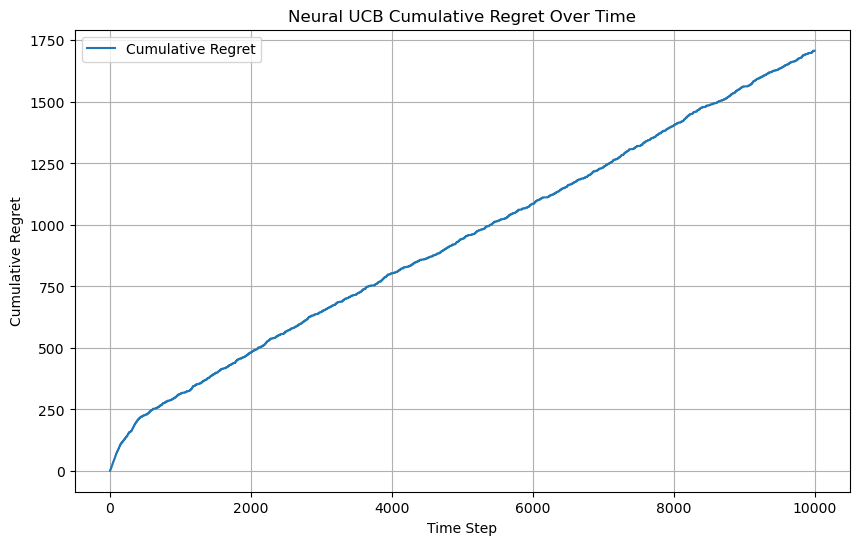

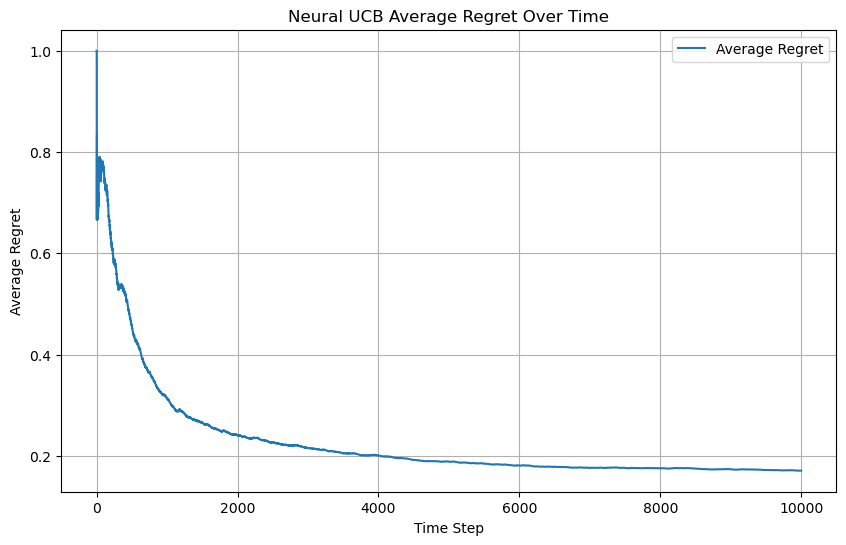

In [9]:
import matplotlib.pyplot as plt

def plot_regret(regret):
    # Convert to numpy array if it's a list
    regret = np.array(regret)
    
    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    cumulative_regret = np.cumsum(regret)
    plt.plot(cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Regret')
    plt.title('Neural UCB Cumulative Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot average regret
    plt.figure(figsize=(10, 6))
    steps = np.arange(1, len(cumulative_regret) + 1)  # create step array first
    average_regret = cumulative_regret / steps
    plt.plot(average_regret, label='Average Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Average Regret')
    plt.title('Neural UCB Average Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
# After training:
plot_regret(regret)